### Installation

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=cba5aed8111119081c1f75311efd0177227ba40aea3a9f5bcbda9c60588e4d1e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.io as pio
import pyspark
from pyspark.sql import*
from pyspark.sql.functions import*
from pyspark import SparkContext, SparkConf
from google.colab import drive
import os
from pyspark.sql import SparkSession
from IPython.display import display
from pyspark.sql.functions import count, when, col, mean
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import DoubleType, IntegerType, FloatType, DecimalType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation

### Mounting Data

In [ ]:
drive.mount('/content/drive')
folder_path = '/content/drive/My Drive/NHANES/'

files = os.listdir(folder_path)
for file in files:
    print(file)

Mounted at /content/drive
diet.csv
demographic.csv
examination.csv
labs.csv
medications.csv
questionnaire.csv


### Creating Spark Session

In [ ]:
spark = SparkSession.builder \
    .appName("NHANES Analysis") \
    .getOrCreate()

### Creating Spark Dataframes

In [ ]:
df_diet = spark.read.csv('/content/drive/My Drive/NHANES/diet.csv', header=True, inferSchema=True)
df_labs = spark.read.csv('/content/drive/My Drive/NHANES/labs.csv', header=True, inferSchema=True)
df_questionnaire = spark.read.csv('/content/drive/My Drive/NHANES/questionnaire.csv', header=True, inferSchema=True)
df_examination = spark.read.csv('/content/drive/My Drive/NHANES/examination.csv', header=True, inferSchema=True)
df_medication = spark.read.csv('/content/drive/My Drive/NHANES/medications.csv', header=True, inferSchema=True, encoding='latin1')
df_demographics = spark.read.csv('/content/drive/My Drive/NHANES/demographic.csv', header=True, inferSchema=True)

### Data Visualization

In [ ]:
pdf_diet = df_diet.toPandas()
pdf_labs = df_labs.toPandas()
pdf_questionnaire = df_questionnaire.toPandas()
pdf_examination = df_examination.toPandas()
pdf_medication = df_medication.toPandas()
pdf_demographics = df_demographics.toPandas()

#data head
display(pdf_diet.head())
display(pdf_labs.head())
display(pdf_questionnaire.head())
display(pdf_examination.head())
display(pdf_medication.head())
display(pdf_demographics.head())

# data description
display(pdf_diet.describe())
display(pdf_labs.describe())
display(pdf_demographics.describe())
display(pdf_examination.describe())
display(pdf_medication.describe())
display(pdf_questionnaire.describe())

,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
0,73557,16888.327864,12930.890649,1,49.0,2.0,2.0,6.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,73558,17932.143865,12684.148869,1,59.0,2.0,2.0,4.0,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0
2,73559,59641.812930,39394.236709,1,49.0,2.0,2.0,18.0,6.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,73560,142203.069917,125966.366442,1,54.0,2.0,2.0,21.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,73561,59052.357033,39004.892993,1,63.0,2.0,2.0,18.0,1.0,1.0,...,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,2.0


,SEQN,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,WTSAF2YR.x,LBXAPB,LBDAPBSI,LBXSAL,...,URXUTL,URDUTLLC,URXUTU,URDUTULC,URXUUR,URDUURLC,URXPREG,URXUAS,LBDB12,LBDB12SI
0,73557,4.3,4.3,39.0,3447.6,11.03,NaN,NaN,NaN,4.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,524.0,386.7
1,73558,153.0,153.0,50.0,4420.0,306.00,NaN,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,507.0,374.2
2,73559,11.9,11.9,113.0,9989.2,10.53,142196.890197,57.0,0.57,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,732.0,540.2
3,73560,16.0,16.0,76.0,6718.4,21.05,NaN,NaN,NaN,NaN,...,0.062,0.0,0.238,0.0,0.0071,0.0,NaN,3.83,NaN,NaN
4,73561,255.0,255.0,147.0,12994.8,173.47,142266.006548,92.0,0.92,4.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.0,166.1


,SEQN,ACD011A,ACD011B,ACD011C,ACD040,ACD110,ALQ101,ALQ110,ALQ120Q,ALQ120U,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,3.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73558,1.0,NaN,NaN,NaN,NaN,1.0,NaN,7.0,1.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,73559,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,73560,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,73561,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


,SEQN,PEASCST1,PEASCTM1,PEASCCT1,BPXCHR,BPAARM,BPACSZ,BPXPLS,BPXPULS,BPXPTY,...,CSXLEAOD,CSXSOAOD,CSXGRAOD,CSXONOD,CSXNGSOD,CSXSLTRT,CSXSLTRG,CSXNART,CSXNARG,CSAEFFRT
0,73557,1,620.0,NaN,NaN,1.0,4.0,86.0,1.0,1.0,...,2.0,1.0,1.0,1.0,4.0,62.0,1.0,NaN,NaN,1.0
1,73558,1,766.0,NaN,NaN,1.0,4.0,74.0,1.0,1.0,...,3.0,1.0,2.0,3.0,4.0,28.0,1.0,NaN,NaN,1.0
2,73559,1,665.0,NaN,NaN,1.0,4.0,68.0,1.0,1.0,...,2.0,1.0,2.0,3.0,4.0,49.0,1.0,NaN,NaN,3.0
3,73560,1,803.0,NaN,NaN,1.0,2.0,64.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,73561,1,949.0,NaN,NaN,1.0,3.0,92.0,1.0,1.0,...,3.0,1.0,4.0,3.0,4.0,NaN,NaN,NaN,NaN,1.0


,SEQN,RXDUSE,RXDDRUG,RXDDRGID,RXQSEEN,RXDDAYS,RXDRSC1,RXDRSC2,RXDRSC3,RXDRSD1,RXDRSD2,RXDRSD3,RXDCOUNT
0,73557,1,99999,None,NaN,NaN,None,None,None,None,None,None,2.0
1,73557,1,INSULIN,d00262,2.0,1460.0,E11,None,None,Type 2 diabetes mellitus,None,None,2.0
2,73558,1,GABAPENTIN,d03182,1.0,243.0,G25.81,None,None,Restless legs syndrome,None,None,4.0
3,73558,1,INSULIN GLARGINE,d04538,1.0,365.0,E11,None,None,Type 2 diabetes mellitus,None,None,4.0
4,73558,1,OLMESARTAN,d04801,1.0,14.0,E11.2,None,None,Type 2 diabetes mellitus with kidney complicat...,None,None,4.0


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,3.0,4.0,NaN,13281.237386,13481.042095,1,112,4.0,4.0,0.84
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,3.0,1.0,1.0,23682.057386,24471.769625,1,108,7.0,7.0,1.78
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,4.0,1.0,3.0,57214.803319,57193.285376,1,109,10.0,10.0,4.51
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,3.0,1.0,4.0,55201.178592,55766.512438,2,109,9.0,9.0,2.52
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,5.0,1.0,5.0,63709.667069,65541.871229,2,116,15.0,15.0,5.00


,SEQN,WTDRD1,WTDR2D,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,...,DRD370QQ,DRD370R,DRD370RQ,DRD370S,DRD370SQ,DRD370T,DRD370TQ,DRD370U,DRD370UQ,DRD370V
count,9813.000000,9813.000000,8661.000000,9813.000000,8783.000000,8661.000000,8661.000000,8706.000000,8783.000000,8797.000000,...,61.000000,5121.000000,171.000000,5121.000000,27.000000,5121.000000,1318.000000,5121.000000,317.000000,5120.0
mean,78644.559971,31713.463364,35931.672555,1.472027,43.793351,1.984528,1.874495,16.176085,4.501423,1.156303,...,1.557377,1.966608,1.766082,1.994728,2.481481,1.742628,2.622155,1.938098,2.400631,2.0
std,2938.592266,36061.598495,51017.340117,1.260325,20.535725,0.123426,0.331310,11.804355,2.184283,0.555685,...,1.443660,0.179675,1.184814,0.072427,2.651130,0.437229,2.793016,0.241001,2.997953,0.0
min,73557.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,-31.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
25%,76092.000000,8731.762120,7255.716712,1.000000,25.000000,2.000000,2.000000,7.000000,3.000000,1.000000,...,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.0
50%,78643.000000,19276.118837,17874.047830,1.000000,49.000000,2.000000,2.000000,16.000000,5.000000,1.000000,...,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.0
75%,81191.000000,42490.159621,44897.265674,1.000000,59.000000,2.000000,2.000000,23.000000,6.000000,1.000000,...,1.000000,2.000000,2.000000,2.000000,2.500000,2.000000,3.000000,2.000000,2.000000,2.0
max,83731.000000,267526.890966,818626.657231,5.000000,91.000000,2.000000,2.000000,74.000000,7.000000,6.000000,...,10.000000,2.000000,8.000000,2.000000,10.000000,2.000000,30.000000,2.000000,30.000000,2.0


,SEQN,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,WTSAF2YR.x,LBXAPB,LBDAPBSI,LBXSAL,...,URXUTL,URDUTLLC,URXUTU,URDUTULC,URXUUR,URDUURLC,URXPREG,URXUAS,LBDB12,LBDB12SI
count,9813.000000,8052.000000,8052.000000,8052.000000,8052.000000,8052.000000,3329.000000,3145.000000,3145.000000,6553.000000,...,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,1261.000000,2662.000000,5316.000000,5316.000000
mean,78644.559971,41.218854,41.218854,121.072529,10702.811525,41.905695,78917.195254,85.898569,0.858986,4.282085,...,0.186950,0.007883,0.150535,0.162162,0.012038,0.177177,1.969072,15.670639,640.100263,472.394865
std,2938.592266,238.910226,238.910226,78.574882,6946.019595,276.261093,71088.020067,25.595258,0.255953,0.343649,...,0.133833,0.088452,0.576409,0.368669,0.034026,0.381890,0.251651,46.735936,751.967084,554.951537
min,73557.000000,0.210000,0.210000,5.000000,442.000000,0.210000,0.000000,20.000000,0.200000,2.400000,...,0.013000,0.000000,0.013000,0.000000,0.001400,0.000000,1.000000,0.280000,18.000000,13.300000
25%,76092.000000,4.500000,4.500000,60.000000,5304.000000,5.020000,33217.405018,68.000000,0.680000,4.100000,...,0.090000,0.000000,0.028000,0.000000,0.002600,0.000000,2.000000,3.210000,381.000000,281.200000
50%,78643.000000,8.400000,8.400000,106.000000,9370.400000,7.780000,56397.702304,84.000000,0.840000,4.300000,...,0.159000,0.000000,0.069000,0.000000,0.005100,0.000000,2.000000,6.240000,514.000000,379.300000
75%,81191.000000,17.625000,17.625000,163.000000,14409.200000,15.295000,99356.561999,101.000000,1.010000,4.500000,...,0.252000,0.000000,0.150000,0.000000,0.010700,0.000000,2.000000,12.435000,711.000000,524.700000
max,83731.000000,9600.000000,9600.000000,659.000000,58255.600000,9000.000000,395978.465792,234.000000,2.340000,5.600000,...,1.290000,1.000000,25.760000,1.000000,0.843400,1.000000,3.000000,1071.300000,26801.000000,19779.100000


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
count,10175.000000,10175.0,10175.000000,10175.000000,10175.000000,673.000000,10175.000000,10175.000000,9813.000000,4213.000000,...,9881.000000,10052.000000,5342.000000,10175.000000,10175.000000,10175.000000,10175.000000,10042.000000,10052.000000,9390.000000
mean,78644.000000,8.0,1.964423,1.508305,31.484128,10.341753,3.091892,3.289828,1.508509,107.478519,...,3.502378,2.735078,3.612879,30585.180933,30585.180933,1.484128,110.926880,10.884983,10.505969,2.252153
std,2937.413829,0.0,0.185243,0.499956,24.421651,6.885479,1.263305,1.613241,0.499953,69.774776,...,1.251080,5.922690,1.321508,26948.427403,27941.005388,0.499773,4.260322,13.878864,13.643064,1.634907
min,73557.000000,8.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,3697.772098,0.000000,1.000000,104.000000,1.000000,1.000000,0.000000
25%,76100.500000,8.0,2.000000,1.000000,10.000000,5.000000,2.000000,2.000000,1.000000,45.000000,...,3.000000,1.000000,3.000000,12754.485277,12561.598665,1.000000,107.000000,5.000000,5.000000,0.870000
50%,78644.000000,8.0,2.000000,2.000000,26.000000,9.000000,3.000000,3.000000,2.000000,103.000000,...,4.000000,1.000000,4.000000,20232.999616,20174.573544,1.000000,111.000000,8.000000,7.000000,1.705000
75%,81187.500000,8.0,2.000000,2.000000,52.000000,16.000000,4.000000,4.000000,2.000000,166.000000,...,4.000000,4.000000,5.000000,36280.427224,36748.217798,2.000000,115.000000,14.000000,14.000000,3.607500
max,83731.000000,8.0,2.000000,2.000000,80.000000,24.000000,5.000000,7.000000,2.000000,239.000000,...,9.000000,99.000000,9.000000,167884.543709,171395.264901,2.000000,118.000000,99.000000,99.000000,5.000000


,SEQN,PEASCST1,PEASCTM1,PEASCCT1,BPXCHR,BPAARM,BPACSZ,BPXPLS,BPXPULS,BPXPTY,...,CSXLEAOD,CSXSOAOD,CSXGRAOD,CSXONOD,CSXNGSOD,CSXSLTRT,CSXSLTRG,CSXNART,CSXNARG,CSAEFFRT
count,9813.000000,9813.000000,9508.000000,320.000000,1961.000000,7535.000000,7542.000000,7549.000000,9511.000000,7564.000000,...,3520.000000,3520.000000,3519.000000,3519.000000,3519.000000,1595.000000,1595.000000,1613.000000,1613.000000,3537.000000
mean,78644.559971,1.064914,660.584034,57.828125,105.534931,1.008096,3.675418,74.416214,1.013668,1.004363,...,2.815625,1.145170,2.155726,2.992327,3.751066,55.746708,1.066458,31.526348,1.199008,1.709075
std,2938.592266,0.354007,275.431642,30.788160,21.516295,0.116644,0.786221,12.367969,0.116116,0.065911,...,0.613697,0.548531,0.667754,0.318464,0.693496,24.649127,0.441677,20.925161,0.690739,0.898975
min,73557.000000,1.000000,7.000000,1.000000,60.000000,1.000000,1.000000,40.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,76092.000000,1.000000,578.000000,56.000000,88.000000,1.000000,3.000000,66.000000,1.000000,1.000000,...,3.000000,1.000000,2.000000,3.000000,4.000000,35.000000,1.000000,16.000000,1.000000,1.000000
50%,78643.000000,1.000000,689.000000,56.000000,102.000000,1.000000,4.000000,74.000000,1.000000,1.000000,...,3.000000,1.000000,2.000000,3.000000,4.000000,53.000000,1.000000,26.000000,1.000000,1.000000
75%,81191.000000,1.000000,832.000000,72.000000,120.000000,1.000000,4.000000,82.000000,1.000000,1.000000,...,3.000000,1.000000,3.000000,3.000000,4.000000,74.000000,1.000000,42.000000,1.000000,2.000000
max,83731.000000,3.000000,2868.000000,122.000000,178.000000,8.000000,5.000000,180.000000,2.000000,2.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,100.000000,5.000000,100.000000,5.000000,5.000000


,SEQN,RXDUSE,RXQSEEN,RXDDAYS,RXDCOUNT
count,20194.000000,20194.00000,14019.000000,14018.000000,14100.000000
mean,78545.350946,1.30311,1.165276,3917.636039,5.907943
std,2933.000334,0.46900,0.498539,13874.344196,3.813666
min,73557.000000,1.00000,1.000000,1.000000,1.000000
25%,75984.250000,1.00000,1.000000,365.000000,3.000000
50%,78506.000000,1.00000,1.000000,1095.000000,5.000000
75%,81063.000000,2.00000,1.000000,2920.000000,8.000000
max,83731.000000,9.00000,3.000000,99999.000000,23.000000


,SEQN,ACD011A,ACD011B,ACD011C,ACD040,ACD110,ALQ101,ALQ110,ALQ120Q,ALQ120U,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
count,10175.000000,5759.0,16.0,171.0,2374.000000,1007.000000,5421.000000,1631.000000,4479.000000,3593.000000,...,15.0,29.0,4179.000000,5024.000000,2765.000000,6103.000000,6020.000000,1478.000000,1478.000000,1478.000000
mean,78644.000000,1.0,8.0,9.0,3.101095,2.956306,1.311197,1.594727,4.709310,1.921514,...,35.0,40.0,412.158411,568.528463,377.322966,315.623464,571.309635,2.583221,2.299729,1.746955
std,2937.413829,0.0,0.0,0.0,1.511821,1.733794,0.545023,0.615303,34.428362,0.853701,...,0.0,0.0,1508.005974,1977.085854,1726.344740,1077.068750,7269.067701,0.784612,1.213281,0.709430
min,73557.000000,1.0,8.0,9.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,35.0,40.0,75.000000,55.000000,50.000000,85.000000,10.000000,1.000000,1.000000,1.000000
25%,76100.500000,1.0,8.0,9.0,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,35.0,40.0,140.000000,125.000000,63.000000,155.000000,25.000000,3.000000,1.000000,1.000000
50%,78644.000000,1.0,8.0,9.0,3.000000,3.000000,1.000000,2.000000,2.000000,2.000000,...,35.0,40.0,165.000000,150.000000,66.000000,185.000000,38.000000,3.000000,2.000000,2.000000
75%,81187.500000,1.0,8.0,9.0,4.000000,5.000000,2.000000,2.000000,4.000000,3.000000,...,35.0,40.0,198.000000,180.000000,70.000000,224.000000,53.000000,3.000000,3.000000,2.000000
max,83731.000000,1.0,8.0,9.0,9.000000,5.000000,9.000000,9.000000,999.000000,3.000000,...,35.0,40.0,9999.000000,9999.000000,9999.000000,9999.000000,99999.000000,9.000000,9.000000,9.000000


### Data Preprocessing in Spark

In [ ]:
def fill_null_with_mean(df):
    numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType, FloatType))]
    for col_name in numeric_cols:
        mean_value = df.select(mean(col(col_name))).first()[0]
        df = df.withColumn(col_name, when(col(col_name).isNull(), mean_value).otherwise(col(col_name)))
    return df

def process_dataframe(df, name):
    print(f"Processing {name}...")
    print(f"Columns before processing: {len(df.columns)}")

    df = df.toDF(*(c.replace('.', '_') for c in df.columns))

    total_rows = df.count()
    acceptable_null_count = total_rows * 0.4

    columns_to_drop = [c for c in df.columns if df.select(count(when(col(c).isNull(), True))).first()[0] > acceptable_null_count]
    print(f"Columns being dropped: {columns_to_drop}")

    if columns_to_drop:
        df = df.drop(*columns_to_drop)

    df = fill_null_with_mean(df)

    print(f"Columns after processing: {len(df.columns)}")
    return df

df_diet = process_dataframe(df_diet, "diet")
df_labs = process_dataframe(df_labs, "labs")
df_medication = process_dataframe(df_medication, "medication")
df_demographics = process_dataframe(df_demographics, "demographics")
df_examination = process_dataframe(df_examination, "examination")

df_medication = df_medication.drop("RXDDRUG", "RXDDRGID", "RXDRSC1", "RXDRSD1", "RXDCOUNT")

print("Number of columns left:")
print("Diet:", len(df_diet.columns))
print("Labs:", len(df_labs.columns))
print("Medication:", len(df_medication.columns))
print("Demographics:", len(df_demographics.columns))
print("Examination:", len(df_examination.columns))


Processing diet...
Columns before processing: 168
Columns being dropped: ['DBD100', 'DR1SKY', 'DRQSDT1', 'DRQSDT2', 'DRQSDT3', 'DRQSDT4', 'DRQSDT5', 'DRQSDT6', 'DRQSDT7', 'DRQSDT8', 'DRQSDT9', 'DRQSDT10', 'DRQSDT11', 'DRQSDT12', 'DRQSDT91', 'DRD350A', 'DRD350AQ', 'DRD350B', 'DRD350BQ', 'DRD350C', 'DRD350CQ', 'DRD350D', 'DRD350DQ', 'DRD350E', 'DRD350EQ', 'DRD350F', 'DRD350FQ', 'DRD350G', 'DRD350GQ', 'DRD350H', 'DRD350HQ', 'DRD350I', 'DRD350IQ', 'DRD350J', 'DRD350JQ', 'DRD350K', 'DRD370A', 'DRD370AQ', 'DRD370B', 'DRD370BQ', 'DRD370C', 'DRD370CQ', 'DRD370D', 'DRD370DQ', 'DRD370E', 'DRD370EQ', 'DRD370F', 'DRD370FQ', 'DRD370G', 'DRD370GQ', 'DRD370H', 'DRD370HQ', 'DRD370I', 'DRD370IQ', 'DRD370J', 'DRD370JQ', 'DRD370K', 'DRD370KQ', 'DRD370L', 'DRD370LQ', 'DRD370M', 'DRD370MQ', 'DRD370N', 'DRD370NQ', 'DRD370O', 'DRD370OQ', 'DRD370P', 'DRD370PQ', 'DRD370Q', 'DRD370QQ', 'DRD370R', 'DRD370RQ', 'DRD370S', 'DRD370SQ', 'DRD370T', 'DRD370TQ', 'DRD370U', 'DRD370UQ', 'DRD370V']
Columns after processing

### One-hot encoding in Spark for String Datatype

In [ ]:
columns_to_encode = [
    "OHX02CTC", "OHX03CTC", "OHX04CTC", "OHX05CTC", "OHX06CTC",
    "OHX07CTC", "OHX08CTC", "OHX09CTC", "OHX10CTC", "OHX11CTC",
    "OHX12CTC", "OHX13CTC", "OHX14CTC", "OHX15CTC", "OHX18CTC",
    "OHX19CTC", "OHX20CTC", "OHX21CTC", "OHX22CTC", "OHX23CTC",
    "OHX24CTC", "OHX25CTC", "OHX26CTC", "OHX27CTC", "OHX28CTC",
    "OHX29CTC", "OHX30CTC", "OHX31CTC"
]

stages = []

for column in columns_to_encode:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    encoder = OneHotEncoder(inputCol=f"{column}_index", outputCol=f"{column}_encoded")
    stages += [indexer, encoder]

pipeline = Pipeline(stages=stages)
df_examination = pipeline.fit(df_examination).transform(df_examination)


In [ ]:
original_columns = [
    "OHX02CTC", "OHX03CTC", "OHX04CTC", "OHX05CTC", "OHX06CTC",
    "OHX07CTC", "OHX08CTC", "OHX09CTC", "OHX10CTC", "OHX11CTC",
    "OHX12CTC", "OHX13CTC", "OHX14CTC", "OHX15CTC", "OHX18CTC",
    "OHX19CTC", "OHX20CTC", "OHX21CTC", "OHX22CTC", "OHX23CTC",
    "OHX24CTC", "OHX25CTC", "OHX26CTC", "OHX27CTC", "OHX28CTC",
    "OHX29CTC", "OHX30CTC", "OHX31CTC"
]

df_examination = df_examination.drop(*original_columns)

df_examination.describe()

DataFrame[summary: string, SEQN: string, PEASCST1: string, PEASCTM1: string, BPAARM: string, BPACSZ: string, BPXPLS: string, BPXPULS: string, BPXPTY: string, BPXML1: string, BPXSY1: string, BPXDI1: string, BPAEN1: string, BPXSY2: string, BPXDI2: string, BPAEN2: string, BPXSY3: string, BPXDI3: string, BPAEN3: string, BMDSTATS: string, BMXWT: string, BMXHT: string, BMXBMI: string, BMXLEG: string, BMXARML: string, BMXARMC: string, BMXWAIST: string, BMXSAD1: string, BMXSAD2: string, BMDAVSAD: string, MGDEXSTS: string, MGQ070: string, MGQ100: string, MGD130: string, MGQ90DG: string, MGAPHAND: string, MGATHAND: string, MGXH1T1: string, MGXH1T1E: string, MGXH2T1: string, MGXH2T1E: string, MGXH1T2: string, MGXH1T2E: string, MGXH2T2: string, MGXH2T2E: string, MGXH1T3: string, MGXH1T3E: string, MGXH2T3: string, MGXH2T3E: string, MGDCGSZ: string, OHDEXSTS: string, OHDDESTS: string, OHX01TC: string, OHX02TC: string, OHX03TC: string, OHX04TC: string, OHX05TC: string, OHX06TC: string, OHX07TC: strin

### Inner Joining all the Files in Spark on basis of SEQN

In [ ]:
df_joined = df_diet.join(df_labs, "SEQN", "inner")
df_joined = df_joined.join(df_demographics, "SEQN", "inner")
#df_joined = df_joined.join(df_examination, "SEQN", "inner")

### Broadcasting df_medications in Spark since it is compartively smaller

In [ ]:
from pyspark.sql.functions import broadcast
df_joined = df_joined.join(broadcast(df_medication), "SEQN", "inner")

In [ ]:
df_joined.describe()

DataFrame[summary: string, SEQN: string, WTDRD1: string, WTDR2D: string, DR1DRSTZ: string, DR1EXMER: string, DRABF: string, DRDINT: string, DR1DBIH: string, DR1DAY: string, DR1LANG: string, DR1MNRSP: string, DR1HELPD: string, DBQ095Z: string, DRQSPREP: string, DR1STY: string, DRQSDIET: string, DR1TNUMF: string, DR1TKCAL: string, DR1TPROT: string, DR1TCARB: string, DR1TSUGR: string, DR1TFIBE: string, DR1TTFAT: string, DR1TSFAT: string, DR1TMFAT: string, DR1TPFAT: string, DR1TCHOL: string, DR1TATOC: string, DR1TATOA: string, DR1TRET: string, DR1TVARA: string, DR1TACAR: string, DR1TBCAR: string, DR1TCRYP: string, DR1TLYCO: string, DR1TLZ: string, DR1TVB1: string, DR1TVB2: string, DR1TNIAC: string, DR1TVB6: string, DR1TFOLA: string, DR1TFA: string, DR1TFF: string, DR1TFDFE: string, DR1TCHL: string, DR1TVB12: string, DR1TB12A: string, DR1TVC: string, DR1TVD: string, DR1TVK: string, DR1TCALC: string, DR1TPHOS: string, DR1TMAGN: string, DR1TIRON: string, DR1TZINC: string, DR1TCOPP: string, DR

### Determining Correlation

In [ ]:
categorical_columns = [field.name for field in df_joined.schema.fields if field.dataType == StringType()]

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="skip")
    for c in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=f"{c}_index", outputCol=f"{c}_encoded")
    for c in categorical_columns
]

stages = indexers + encoders
pipeline = Pipeline(stages=stages)

df_transformed = pipeline.fit(df_joined).transform(df_joined)

assembler = VectorAssembler(inputCols=[f"{c}_encoded" for c in categorical_columns], outputCol="features")
df_vector = assembler.transform(df_transformed)

try:
    corr_matrix = Correlation.corr(df_vector, "features").collect()[0][0]
    print("Correlation matrix calculated successfully.")
except Exception as e:
    print(f"An error occurred: {e}")


An error occurred: An error occurred while calling z:org.apache.spark.ml.stat.Correlation.corr.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3652.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3652.0 (TID 3552) (79525d712843 executor driver): java.lang.IllegalArgumentException: requirement failed: Vector should have dimension larger than zero.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.stat.SummarizerBuffer.add(Summarizer.scala:476)
	at org.apache.spark.mllib.stat.Statistics$.$anonfun$colStats$1(Statistics.scala:59)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:196)
	at scala.collection.TraversableOnce$folder$1.apply(TraversableOnce.scala:194)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(Traversabl

In [ ]:
# Correctly identifying numerical columns
numerical_cols = [field.name for field in df_joined.schema.fields
                  if isinstance(field.dataType, (DoubleType, IntegerType, FloatType, DecimalType))]

from pyspark.sql.functions import col

# Checking for nulls in numerical columns and filling them
for column in numerical_cols:
    if df_joined.filter(col(column).isNull()).count() > 0:
        df_joined = df_joined.na.fill({column: 0})  # Filling nulls with 0 or an appropriate value

# Re-run the VectorAssembler
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
df_vector = assembler.transform(df_joined)


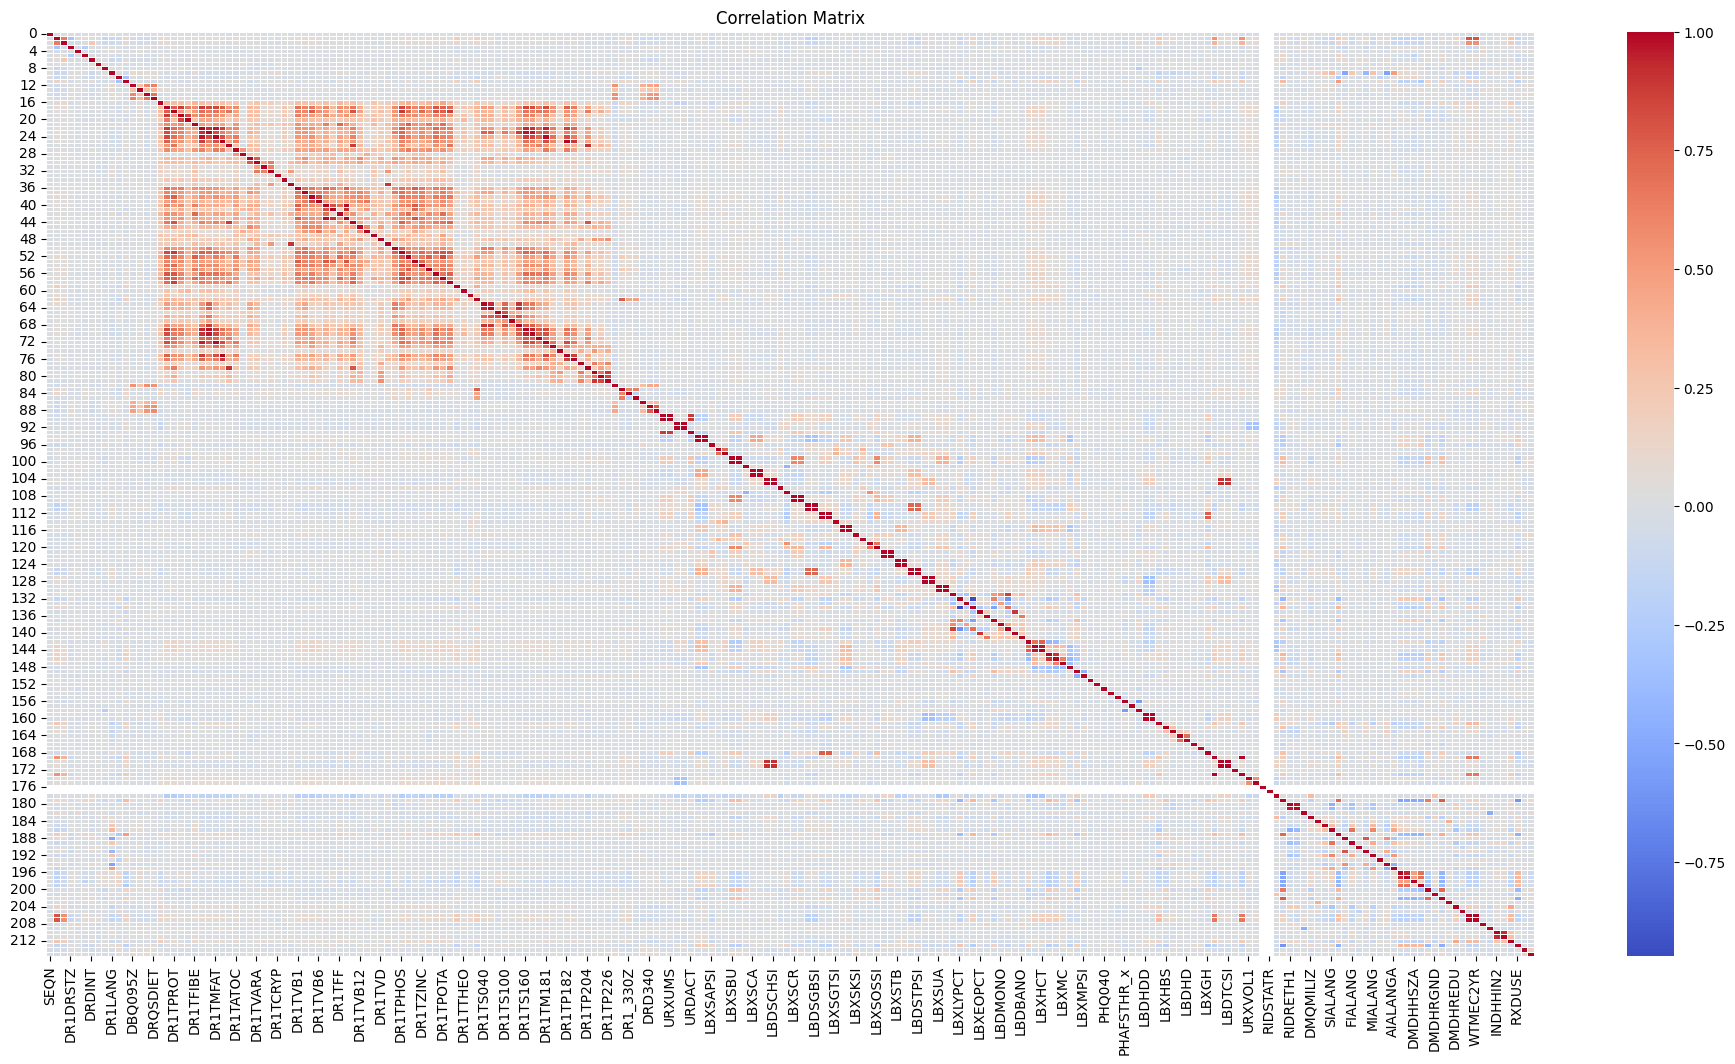

In [ ]:
corr_matrix = Correlation.corr(df_vector, "features").collect()[0][0]

corr_matrix_pd = corr_matrix.toArray().tolist()
columns = df_joined.columns
corr_matrix_df = spark.createDataFrame(corr_matrix_pd, columns)

plt.figure(figsize=(24, 12))
sns.heatmap(corr_matrix_df.toPandas(), cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

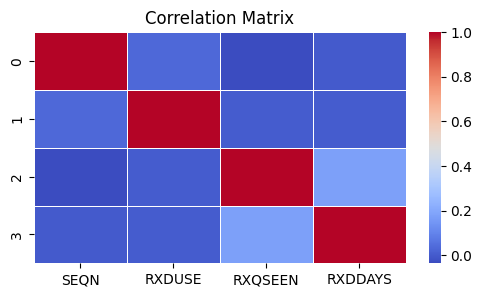

In [ ]:
assembler = VectorAssembler(inputCols=df_medication.columns, outputCol="features")
df_vector = assembler.transform(df_medication)
corr_matrix = Correlation.corr(df_vector, "features").collect()[0][0]
corr_matrix_pd = corr_matrix.toArray().tolist()
columns = df_medication.columns
corr_matrix_df = spark.createDataFrame(corr_matrix_pd, columns)
plt.figure(figsize=(6, 3))
sns.heatmap(corr_matrix_df.toPandas(), cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

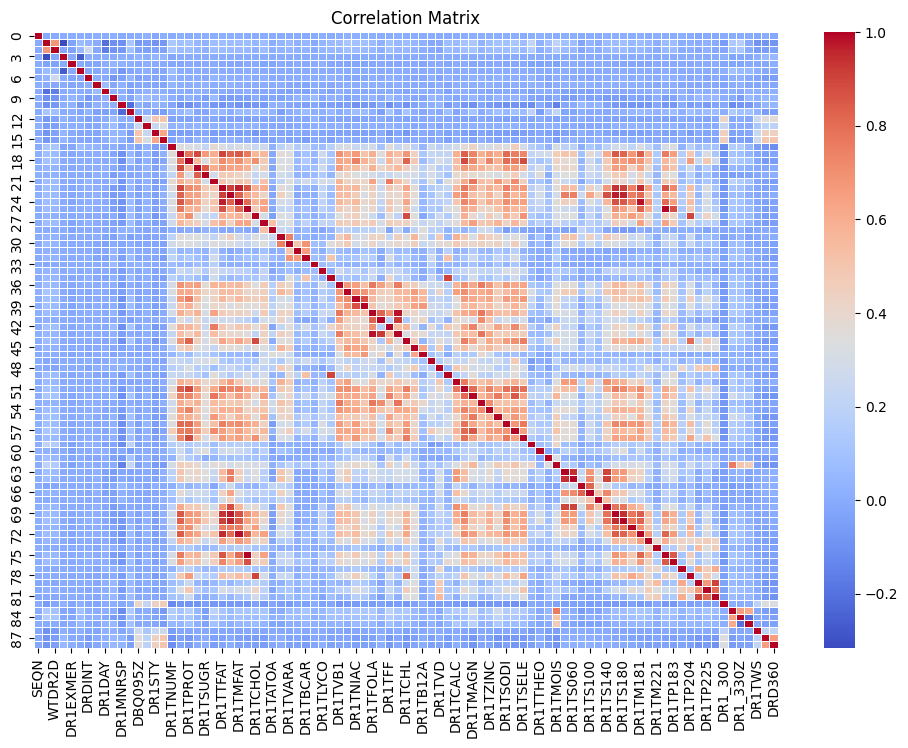

In [ ]:
assembler = VectorAssembler(inputCols=df_diet.columns, outputCol="features")
df_vector = assembler.transform(df_diet)
corr_matrix = Correlation.corr(df_vector, "features").collect()[0][0]
corr_matrix_pd = corr_matrix.toArray().tolist()
columns = df_diet.columns
corr_matrix_df = spark.createDataFrame(corr_matrix_pd, columns)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_df.toPandas(), cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

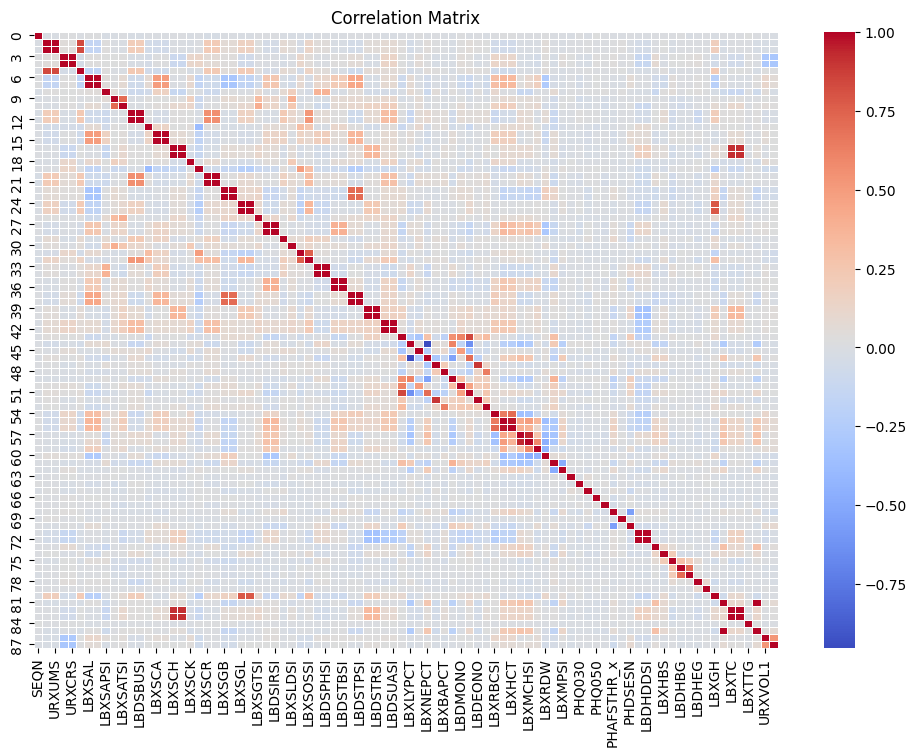

In [ ]:
assembler = VectorAssembler(inputCols=df_labs.columns, outputCol="features")
df_vector = assembler.transform(df_labs)

corr_matrix = Correlation.corr(df_vector, "features").collect()[0][0]
corr_matrix_pd = corr_matrix.toArray().tolist()
columns = df_labs.columns
corr_matrix_df = spark.createDataFrame(corr_matrix_pd, columns)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_df.toPandas(), cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

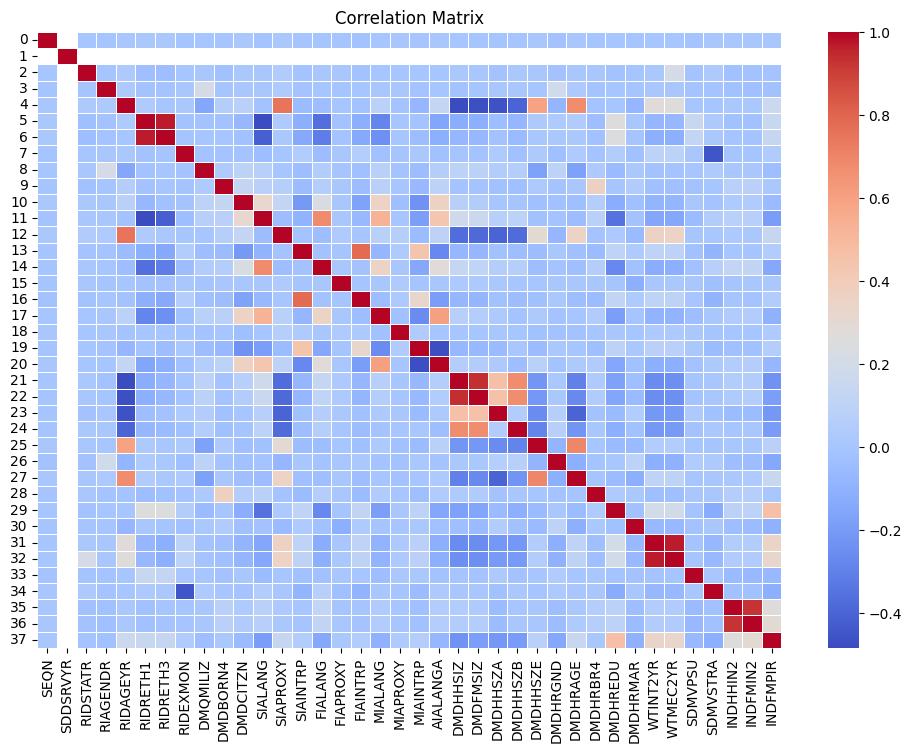

In [ ]:
assembler = VectorAssembler(inputCols=df_demographics.columns, outputCol="features")
df_vector = assembler.transform(df_demographics)

corr_matrix = Correlation.corr(df_vector, "features").collect()[0][0]
corr_matrix_pd = corr_matrix.toArray().tolist()
columns = df_demographics.columns
corr_matrix_df = spark.createDataFrame(corr_matrix_pd, columns)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_df.toPandas(), cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Principal Component Analysis Using Spark

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import PCA

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
df_assembled = assembler.transform(df_joined)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
df_scaled = scaler.fit(df_assembled).transform(df_assembled)

n_components = 15
pca = PCA(k=n_components, inputCol="scaledFeatures", outputCol="pcaFeatures")

pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)
df_pca.select("pcaFeatures").show(truncate=False)

print("Explained Variance Ratio:", pca_model.explainedVariance.toArray())

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pcaFeatures                                                                                                                                                                                                                                                                                           |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[2.8041052123893206,-3.9686376824102743,-3.3204298812105284,-2.2729557218170124,-0.9022883723434791,-1.16519

### K-Means Clustering in Spark

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
df_assembled = assembler.transform(df_joined)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
df_scaled = scaler.fit(df_assembled).transform(df_assembled)
for n_components in range(2, 16):
    pca = PCA(k=n_components, inputCol="scaledFeatures", outputCol="pcaFeatures")
    pca_model = pca.fit(df_scaled)
    df_pca = pca_model.transform(df_scaled)
    print(f"PCA components: {n_components}, Explained Variance: {pca_model.explainedVariance.toArray()}")
    for k in range(2, 7):
        kmeans = KMeans(k=k, seed=1, featuresCol="pcaFeatures")
        model = kmeans.fit(df_pca.select("pcaFeatures"))
        predictions = model.transform(df_pca)

        # Evaluate clustering
        evaluator = ClusteringEvaluator()
        silhouette_score = evaluator.evaluate(predictions)
        print(f"Number of PCA components: {n_components}, K: {k}, Silhouette score: {silhouette_score}")



PCA components: 2, Explained Variance: [0.11165157 0.04325276]
Number of PCA components: 2, K: 2, Silhouette score: 0.16529085341146746
Number of PCA components: 2, K: 3, Silhouette score: -0.07925141371095354
Number of PCA components: 2, K: 4, Silhouette score: -0.1293748983096989
Number of PCA components: 2, K: 5, Silhouette score: -0.31202190180428
Number of PCA components: 2, K: 6, Silhouette score: -0.3230403275528906
PCA components: 3, Explained Variance: [0.11165157 0.04325276 0.03323648]
Number of PCA components: 3, K: 2, Silhouette score: 0.16839798836175116
Number of PCA components: 3, K: 3, Silhouette score: -0.08571839548367387
Number of PCA components: 3, K: 4, Silhouette score: -0.17991532826510062
Number of PCA components: 3, K: 5, Silhouette score: -0.1893444931516993
Number of PCA components: 3, K: 6, Silhouette score: -0.24908684676248521
PCA components: 4, Explained Variance: [0.11165157 0.04325276 0.03323648 0.02713401]
Number of PCA components: 4, K: 2, Silhouette 

### Bisecting K-Means in PySpark

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

for k in range(2, 6):
    bkm = BisectingKMeans().setK(k).setSeed(1).setFeaturesCol("pcaFeatures")
    model = bkm.fit(df_pca)
    predictions = model.transform(df_pca)
    evaluator = ClusteringEvaluator(featuresCol="pcaFeatures")
    silhouette = evaluator.evaluate(predictions)
    print(f"For k = {k}, Silhouette with squared euclidean distance = {silhouette}")

    centers = model.clusterCenters()
    print(f"Cluster Centers for k = {k}:")
    for center in centers:
        print(center)
    print("\n")


For k = 2, Silhouette with squared euclidean distance = 0.3987843794063189
Cluster Centers for k = 2:
[-7.0317136   0.009061    0.26914353  0.14678991 -0.08966981  0.04032635
 -0.10044083  0.03177456 -0.0105344  -0.06147617 -0.01654834 -0.08781819
  0.01385902 -0.08260791 -0.03755937]
[ 1.93189007 -0.00248941 -0.07394438 -0.040329    0.02463585 -0.01107925
  0.02759507 -0.00872973  0.00289422  0.01688994  0.00454648  0.02412713
 -0.00380762  0.02269566  0.01031904]


For k = 3, Silhouette with squared euclidean distance = 0.13822484143172484
Cluster Centers for k = 3:
[-7.0317136   0.009061    0.26914353  0.14678991 -0.08966981  0.04032635
 -0.10044083  0.03177456 -0.0105344  -0.06147617 -0.01654834 -0.08781819
  0.01385902 -0.08260791 -0.03755937]
[ 1.78351859 -2.08183473  0.06785293 -0.15604467 -0.0551465  -0.06711537
  0.17031653 -0.13961607 -0.07780689  0.1552025   0.15256379 -0.24015875
  0.00437398 -0.02716407  0.13293139]
[ 2.15070447  3.09557489 -0.28556454  0.13174245  0.14386

In [ ]:
k2_predictions = predictions.filter(predictions.prediction < 2)
collected_data = k2_predictions.select("pcaFeatures", "prediction").collect()
features = np.array([x['pcaFeatures'].toArray() for x in collected_data])
cluster_assignments = np.array([x['prediction'] for x in collected_data])
df_plot = pd.DataFrame(features[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
df_plot['Cluster'] = cluster_assignments
df_plot['Cluster'] = df_plot['Cluster'].astype(str)
custom_colors = ['#1f77b4', '#ff7f0e']
fig = px.scatter_3d(df_plot, x='PCA1', y='PCA2', z='PCA3',
                    color='Cluster', title='3D Scatter Plot of K-means Clustering with k=2',
                    labels={'Cluster': 'Cluster ID'},
                    color_discrete_sequence=custom_colors,
                    symbol='Cluster', symbol_sequence=['circle', 'square'],
                    opacity=0.7, width=800, height=600)
fig.show()


In [ ]:
k3_predictions = predictions.filter(predictions.prediction < 3)
collected_data = k3_predictions.select("pcaFeatures", "prediction").collect()
features = np.array([x['pcaFeatures'].toArray() for x in collected_data])
cluster_assignments = np.array([x['prediction'] for x in collected_data])
df_plot = pd.DataFrame(features[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
df_plot['Cluster'] = cluster_assignments
df_plot['Cluster'] = df_plot['Cluster'].astype(str)
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
fig = px.scatter_3d(df_plot, x='PCA1', y='PCA2', z='PCA3',
                    color='Cluster', title='3D Scatter Plot of K-means Clustering with k=3',
                    labels={'Cluster': 'Cluster ID'},
                    color_discrete_sequence=custom_colors,
                    symbol='Cluster', symbol_sequence=['circle', 'square', 'diamond'],
                    opacity=0.7, width=800, height=600)
fig.show()


In [ ]:
k4_predictions = predictions.filter(predictions.prediction < 4)
collected_data = k4_predictions.select("pcaFeatures", "prediction").collect()
features = np.array([x['pcaFeatures'].toArray() for x in collected_data])
cluster_assignments = np.array([x['prediction'] for x in collected_data])
df_plot = pd.DataFrame(features[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
df_plot['Cluster'] = cluster_assignments
df_plot['Cluster'] = df_plot['Cluster'].astype(str)
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
fig = px.scatter_3d(df_plot, x='PCA1', y='PCA2', z='PCA3',
                    color='Cluster', title='3D Scatter Plot of K-means Clustering with k=4',
                    labels={'Cluster': 'Cluster ID'},
                    color_discrete_sequence=custom_colors,
                    symbol='Cluster', symbol_sequence=['circle', 'square', 'diamond', 'cross'],
                    opacity=0.7, width=800, height=600)
fig.show()


In [ ]:
k5_predictions = predictions.filter(predictions.prediction < 5)
collected_data = k5_predictions.select("pcaFeatures", "prediction").collect()
features = np.array([x['pcaFeatures'].toArray() for x in collected_data])
cluster_assignments = np.array([x['prediction'] for x in collected_data])
df_plot = pd.DataFrame(features[:, :3], columns=['PCA1', 'PCA2', 'PCA3'])
df_plot['Cluster'] = cluster_assignments
df_plot['Cluster'] = df_plot['Cluster'].astype(str)
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
fig = px.scatter_3d(df_plot, x='PCA1', y='PCA2', z='PCA3',
                    color='Cluster', title='3D Scatter Plot of K-means Clustering with k=5',
                    labels={'Cluster': 'Cluster ID'},
                    color_discrete_sequence=custom_colors,
                    symbol='Cluster', symbol_sequence=['circle', 'square', 'diamond', 'cross', 'x'],
                    opacity=0.7, width=800, height=600)
fig.show()


### Stopping the Spark Session

In [ ]:
spark.stop()